# A 1D example with Normal modes

In this example we will solve the classic error free SOLA problem in 1D:
$$
\begin{gather}
    \nonumber \text{Given the data constraint} \\ 
    d_i = G(m) = \int_0^1 K_i(x) m(x) dx \\
    \nonumber \text{We want to find} \\
    p_i = T(m) = \int_0^1 \Tau_i(x) m(x) dx
\end{gather}
$$

First we import the needed modules

In [13]:
import sys
sys.path.append('/home/adrian/PhD/BGSOLA/SOLA_DLI/core')
from core.main_classes.spaces import RN, PCb
from core.main_classes.domains import HyperParalelipiped
from core.main_classes.mappings import *

# This contains various functions for loading and handling normal mode data 
from core.aux.normal_data import * 

Then we import the kernel data

In [79]:
# Directory where all the data is and whether we want vs or vp etc
data_directory = '/home/adrian/PhD/BGSOLA/mysola/normal_data/kernels_modeplotaat_Adrian'
kernel_type = 'vp'
# Read the file that contains all available modes 
kernel_discrete_domain, discrete_sensitivity_kernels = load_normal_data(kernel_type, data_directory)

This data is, however, discrete. We need the sensitivity kernels to be functions defined on a continuous domain. We create interpolation functions based on the discrete sensitivity kernels using the Interpolation_1D class in functions.py. (Important discussion: what errors are introduced by the discreteness of the sensitivity kernels and the choice of interpolation for it?)

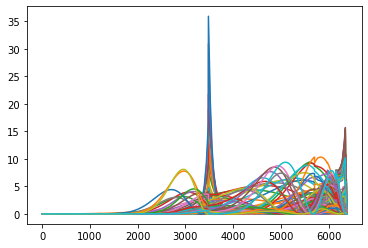

In [80]:
%matplotlib inline
# Create Earth 1D domain
EarthDomain = HyperParalelipiped(bounds=[[kernel_discrete_domain[0], 
                                          kernel_discrete_domain[-1]]], 
                                          fineness=1000)

sensitivity_kernels = []
how_many_kernels_to_load = 100#len(discrete_sensitivity_kernels)
for i, discrete_sensitivity_kernel in enumerate(discrete_sensitivity_kernels[0:how_many_kernels_to_load]):
    sensitivity_kernels.append(Interpolation_1D(values=discrete_sensitivity_kernel,
                                                raw_domain=kernel_discrete_domain,
                                                domain=EarthDomain))
    plt.plot(kernel_discrete_domain, discrete_sensitivity_kernel)

Then we create the needed spaces

In [81]:
# Create Model space
M = PCb(domain=EarthDomain)
# Create Data space (must know number of sensitivity kernels)
D = RN(dimension=how_many_kernels_to_load)
# Create Property space (must know number of target kernels)
no_targets = 100  # Number of targets we will use
P = RN(dimension=no_targets)


And the mappings. For the property mapping we also need to create some target kernels. 

In [82]:
# Create Data mapping (must have the sensitivity kernels)
G = IntegralMapping(domain=M, codomain=D, kernels=sensitivity_kernels)

# Create Target kernels
width = 1000 # same units as domain (km here)
enquiry_points = np.linspace(EarthDomain.bounds[0][0], 
                             EarthDomain.bounds[0][1], 
                             no_targets) # these are the locations where we center our targets

target_kernels = []
for i in range(no_targets):
    target_kernels.append(Gaussian_1D(domain=EarthDomain,
                               center=enquiry_points[i],
                               width=width))
# You can also try to replace Gaussian_1D with Boxcar_1D or DGaussian_1D
T = IntegralMapping(domain=M, codomain=P, kernels=target_kernels)

Now we generate some fake true model and data

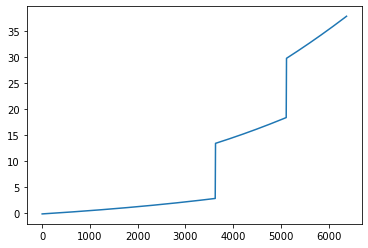

In [83]:
true_model = Random_1D(domain=EarthDomain, seed=1)
%matplotlib inline
true_model.plot()

data = G.map(true_model)

Now we obtain the least norm solution

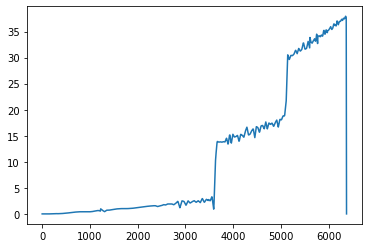

In [84]:
# Find pseudo-inverse
G_adjoint = G.adjoint()
# Normally we would now compute this
"""G_pseudo_inverse = G_adjoint * (G * G_adjoint).invert()"""
# But computing (G * G_adjoint) is equivalent to computing the associated Gram
# matrix for the G mapping  which can be done faster with the method
# "_compute_GramMatrix()". The resulting Gram matrix can then be used to form a
# FiniteLinearMapping:
Lambda = G._compute_GramMatrix()
# Now we invert Lambda
Lambda_inv = Lambda.invert()
# And finally find the least norm solution
least_norm_solution = G_adjoint.map(Lambda_inv.map(data))
# And we plot it
plt.plot(EarthDomain.mesh, 
         least_norm_solution.evaluate(EarthDomain.mesh)[1])

Now we want to compute the Resolving kernels. For this we need the X matrix: 

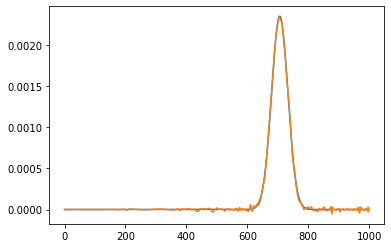

In [85]:
Gamma = T * G_adjoint
X = Gamma * Lambda_inv
resolving_kernels = np.dot(X.matrix, sensitivity_kernels)
%matplotlib inline
# Choose what resolving kernel to plot below
plt.figure(1)
plt.plot(target_kernels[70].evaluate(EarthDomain.mesh)[1])
plt.plot(resolving_kernels[70].evaluate(EarthDomain.mesh)[1])
plt.show()

And we compute the least norm solution property

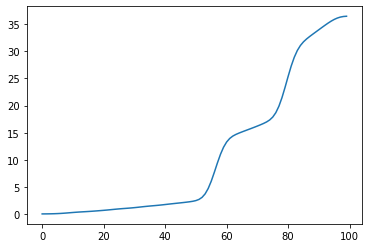

In [86]:
least_norm_property = X.map(data)

plt.plot(least_norm_property)

To compute the bounds we will need the diagonal of $\mathcal{H} = \chi - \Gamma \Lambda^{-1} \Gamma^*$ matrix, which are simply $\int (T_i - A_i)^2$ and a norm Bound $M$. Let's start by computing a norm bound using piecewise functions.

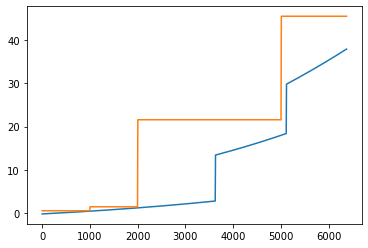

2056.915257452288 1347.1694009166674


In [87]:
intervals = np.array([0,1000, 2000, 5000, EarthDomain.bounds[0][1]])
values = true_model.evaluate(intervals[1:])[1] * 1.2
upper_bound_function = Piecewise_1D(domain=EarthDomain, 
                 intervals=intervals,
                 values=values)
plt.figure()
plt.plot(EarthDomain.mesh, true_model.evaluate(EarthDomain.mesh)[1])
plt.plot(EarthDomain.mesh, upper_bound_function.evaluate(EarthDomain.mesh)[1])
plt.show()

norm_bound = M.norm(upper_bound_function)
least_norm = M.norm(least_norm_solution)
print(norm_bound, least_norm)

In [88]:
bounds = []
for resolving, target in zip(resolving_kernels, target_kernels):
    H_diag = M.norm(target - resolving)
    bound = np.sqrt((norm_bound**2 - least_norm**2))*H_diag
    bounds.append(bound)
bounds = np.array(bounds).reshape((no_targets, 1))

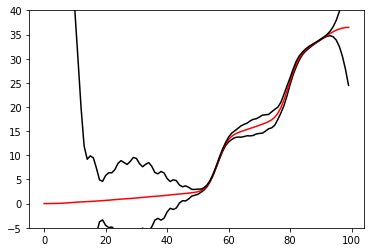

In [89]:
plt.figure(2)
plt.plot(least_norm_property - bounds, color='black')
plt.plot(least_norm_property, color='red')
plt.plot(least_norm_property + bounds, color='black')
plt.ylim(-5,40)
plt.show()